In [1]:
import pandas as pd
import os
from tabulate import tabulate
from simulations_2d import *
import matplotlib.colors as mcolors
import random

def moveUp(fn, times = 1):
    for _ in range(times):
        fn = os.path.dirname(fn)
    return fn

def format_value(value):
    if isinstance(value, int):
        return str(value)
    return "{:.4f}".format(value)


def create_latex_subtables(df, sigma):
    # Filter the dataframe by the sigma value
    df_sigma = df[df['sigma'] == sigma]

    # Get the unique alpha values, sorted
    alphas = sorted(df_sigma['alpha'].unique())

    # Initialize the final LaTeX table string
    latex_tables = "\\begin{subtable}{\\textwidth}\n\\centering\n"
    
    d = 0.25

    # Iterate over each alpha value
    for alpha in alphas:
        # Get the subset of the dataframe with the current alpha value
        df_alpha = df_sigma[df_sigma['alpha'] == alpha].sort_values('N')

        # Remove the 'alpha', 'S', 'lambda', 'nu', 'sigma', 'Y_jumpfrom', and 'Y_jumpto' columns
        df_alpha = df_alpha.drop(['S', 'lambda', 'nu', 'sigma', 'Y_jumpfrom', 'Y_jumpto'], axis=1)
        
        # reorder columns
        cols = ['N', 'alpha', 'Y_jumpsize', 'mse', 'mse_est', 'bias', 'jump_neg', 'jump_pos']
        df_alpha = df_alpha[cols]
        
        df_alpha.rename(columns={'mse' : 'MSE',
                                'jump_neg' : 'FNR',
                                'jump_pos' : 'FPR'}, 
                        inplace=True)
        
        df_alpha['N'] = df_alpha['N'].astype(int)
        # format value on df_alpha
        df_alpha = df_alpha.applymap(format_value)


        # Generate the LaTeX table
        latex_table = tabulate(df_alpha, tablefmt="latex_booktabs", headers="keys", showindex=False)

        # Get the lambda and nu values
        lambda_val = df_sigma.loc[df_sigma['alpha'] == alpha, 'lambda'].values[0]
        nu_val = df_sigma.loc[df_sigma['alpha'] == alpha, 'nu'].values[0]

        # Add the sub-table to the final LaTeX tables string
        nrow = df_alpha.shape[1]
        latex_tables += " d = %.2f \\\\ \n%s \n" % (d, latex_table)
        latex_tables += "\\\\ SURE: $\\lambda$ = %.4f, $\\nu$ = %.4f  \\\\ \n\n" % (lambda_val, nu_val)

        d += 0.25

    # replace the names that require maths (tabulate processes them as text)
    latex_tables = latex_tables.replace(f"alpha", f"$ \\alpha $")
    latex_tables = latex_tables.replace("Y\\_jumpsize", "$ \\hat{\\alpha} $")
    latex_tables = latex_tables.replace("mse\\_est", "MSE $\\tau_{\\mathrm{FD}}$")
    latex_tables = latex_tables.replace("bias", "Bias $\\tau_{\\mathrm{FD}}$")
        


    latex_tables += "\\end{subtable}"
    
    return latex_tables



def getTrueFunction(resolution=0.01):
    
    # now sample the function values on the data points
    xmin, xmax = 0, 1
    ymin, ymax = 0, 1
    resolution = resolution # 100 by 100 grid
    x, y = np.meshgrid(np.arange(xmin, xmax, resolution), np.arange(ymin, ymax, resolution))
    grid = np.dstack((x, y))
    grid_f = np.zeros(grid.shape[:2])


    # Compute the function values on the grid
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            grid_f[i, j] = f(grid[i, j][0], grid[i, j][1], jsize)
            
    return grid_f

    

In [3]:

#----------------
# prepare 
#----------------


# paths
# dir = os.path.dirname(__file__)
# get directory above
main_dir = "/Users/davidvandijcke/Dropbox (University of Michigan)/rdd" #  "/home/dvdijcke/" # moveUp(dir, 4)
data_in = os.path.join(main_dir, 'data', 'in')    
data_out = os.path.join(main_dir, 'data', 'out')  

# overleaf synced dropbox folder (change to your own overleaf path)
ovrlf = "/Users/davidvandijcke/Dropbox (University of Michigan)/Apps/Overleaf/rdd/"
tabs_dir = os.path.join(ovrlf, "tabs")
figs_dir = os.path.join(ovrlf, "figs")

# tabs_dir = main_dir
# figs_dir = main_dir

# pull data from S3

# run the command string in cli
fn = "2022-06-28"
ffrom = f"'s3://ipsos-dvd/fdd/data/{fn}/'"
fto = f"'/Users/davidvandijcke/Dropbox (University of Michigan)/rdd/data/out/simulations/{fn}/'"
#!aws s3 sync $ffrom $fto --profile ipsos

# read all files in fto
df = pd.concat([pd.read_csv(os.path.join(data_out, 'simulations', fn, file)) for file in os.listdir(os.path.join(data_out, 'simulations', fn)) if file.endswith(".csv")])



In [ ]:

#df = pd.read_csv("/Users/davidvandijcke/Downloads/simulations_2d_sigma_0.01_jsize_0.10661253981895451 (1).csv")

#----------------
# create latex tables
#----------------


# Group by 'alpha', 'N', and 'S' and calculate the mean 'Y_jumpsize'
df['Y_jumpsize'] = df['Y_jumpsize'].abs()
df['bias'] = df['Y_jumpsize'].abs() - df['alpha']
df['mse_est'] = df['bias']**2 
mean_jumpsize = df.groupby(['alpha', 'N', 'S', 's']).agg({'Y_jumpsize' : 'mean', 
                                            'mse' : 'mean', 
                                            'mse_est' : 'mean',
                                            'bias' : 'mean',
                                            'jump_neg' : 'mean',
                                            'jump_pos' : 'mean',
                                            'Y_jumpfrom' : 'mean',
                                            'Y_jumpto' : 'mean',
                                            'lambda' : 'mean', 
                                            'nu' : 'mean', 
                                            'sigma' : 'mean'}).reset_index()
mean_jumpsize = mean_jumpsize.groupby(['alpha', 'N', 'S']).agg({'Y_jumpsize' : 'mean', 
                                            'mse' : 'mean', 
                                            'mse_est' : 'mean',
                                            'bias' : 'mean',
                                            'jump_neg' : 'mean',
                                            'jump_pos' : 'mean', 
                                            'Y_jumpfrom' : 'mean',
                                            'Y_jumpto' : 'mean',
                                            'lambda' : 'mean', 
                                            'nu' : 'mean', 
                                            'sigma' : 'mean'}).reset_index()


# df = df[df['alpha'] > 0.107]
# df = df[df['Y_jumpsize'].abs() > np.sqrt(df['nu'])]
# df['Y_jumpsize'].abs().mean()

# Generate the LaTeX tables for each sigma value
latex_table_sigma_0_01 = create_latex_subtables(mean_jumpsize, 0.01)
latex_table_sigma_0_05 = create_latex_subtables(mean_jumpsize, 0.05)

# Write the tables to separate .tex files
with open(os.path.join(tabs_dir, 'table_sigma_0_01.tex'), 'w') as f:
    f.write(latex_table_sigma_0_01)

with open(os.path.join(tabs_dir, 'table_sigma_0_05.tex'), 'w') as f:
    f.write(latex_table_sigma_0_05)



In [8]:

#----------------
# plot image
#----------------
random.seed(9873)


# extract parameters
sigma = 0.05
S = 32
temp = df[df.sigma == sigma].drop_duplicates(subset=['sigma', 'alpha'])
temp = temp[temp.alpha == max(temp.alpha)]
lmbda, nu, jsize = temp[['lambda', 'nu', 'alpha']].values[0]

X, Y, U = generate2D(jsize=jsize, sigma=sigma, N=10000)

resolution = 1/int(np.sqrt(Y.size*2/3))
model = FDD(Y, X, level = S, lmbda = lmbda, nu = nu, iter = 10000, tol = 5e-5, resolution=resolution,
    pick_nu = "MS", scaled = True, scripted = False)

u, jumps, J_grid, nrj, eps, it = model.run()


    

/Users/davidvandijcke/miniconda3/envs/myenv/lib/python3.9/site-packages/FDD/primaldual_multi_scaled_tune.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
/Users/davidvandijcke/miniconda3/envs/myenv/lib/python3.9/site-packages/FDD/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res


In [19]:
def plotImage(u, alpha=0.5, outline=False, tcks=[0,0.2,0.4,0.6,0.8,1], cmap="coolwarm_r", eg="face", rasterize=True):
    fig, ax = plt.subplots(figsize=(5, 5))
    img = ax.imshow(u, cmap=cmap, alpha=alpha, vmin=0, vmax=1, rasterized=rasterize)
    cb = fig.colorbar(img, orientation="horizontal", fraction=0.03, pad=0.04, drawedges=False)
    plt.axis("off")
    plt.tight_layout()
    ax.set_aspect("equal")
    cb.set_ticks(tcks)
    cb.update_ticks()
    cb.outline.set_edgecolor('lightgrey')
    cb.outline.set_visible(outline)
    
    return fig, ax

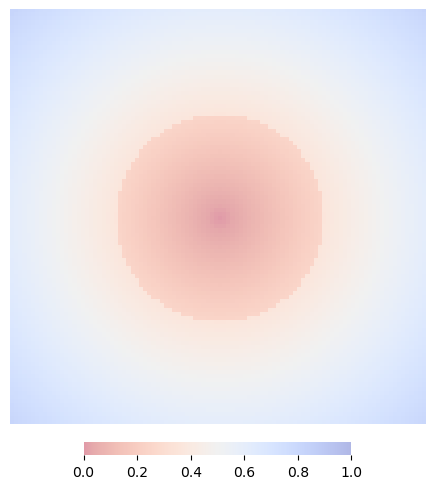

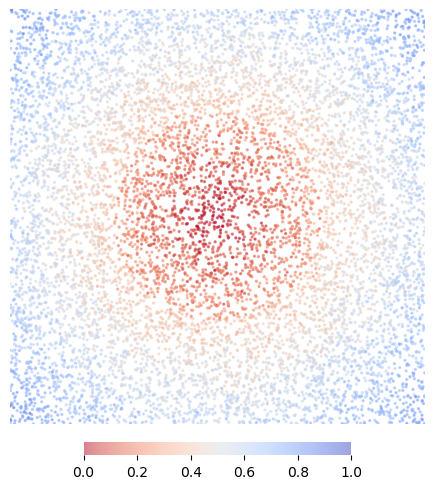

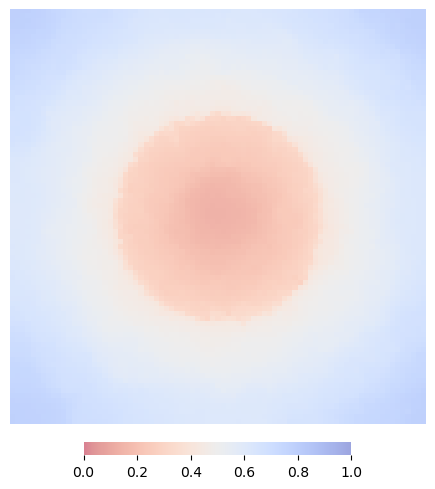

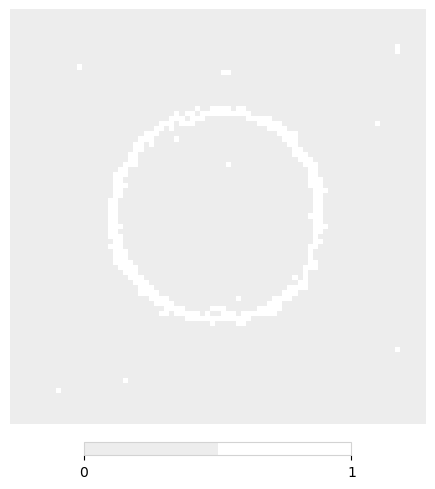

In [25]:

# Define a more subtle color palette with shades of blue
colors = ["#f0f9e8", "#bae4bc", "#7bccc4", "#43a2ca", "#0868ac"]

# Create a colormap from the color list
cmap = "coolwarm_r" # mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)



# plot underlying function
grid_f = getTrueFunction()
plotImage(grid_f, alpha=0.4)
plt.savefig(os.path.join(figs_dir, 'simulation_2d_truth.pdf'), bbox_inches='tight')

# plot point cloud
fig, ax = plt.subplots(figsize=(5, 5))
img = ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap, s=2, alpha=0.5, vmin=0, vmax=1, rasterized=True)
cb = fig.colorbar(img, orientation="horizontal", fraction=0.03, pad=0.04)
plt.axis("off")
plt.tight_layout()
plt.margins(0)
ax.set_aspect("equal")
cb.outline.set_edgecolor("grey")
cb.outline.set_visible(False)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.update_ticks()
plt.savefig(os.path.join(figs_dir, 'simulation_2d_pointcloud.pdf'), bbox_inches='tight')

# plot estimated function
plotImage(u)
plt.savefig(os.path.join(figs_dir, 'simulation_2d_u.pdf'), bbox_inches='tight')

# plot boundary
colors = ["lightgrey", "white"]
cmap = mcolors.ListedColormap(colors) 
plotImage(J_grid,  alpha=0.4, cmap=cmap, tcks=[0,1], outline=True)
plt.savefig(os.path.join(figs_dir, 'simulation_2d_Jgrid.pdf'), bbox_inches='tight')
